In [1]:
import os
import warnings
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # ignore broken image streams

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# ==============================
# Ignore warnings
# ==============================
warnings.filterwarnings("ignore", message="Palette images with Transparency expressed in bytes should be converted to RGBA images")

# ==============================
# Path to dataset
# ==============================
train_dir = r"D:\Downloads\deepfake\project\train"

# ==============================
# Image parameters
# ==============================
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  

# ==============================
# Data generators
# ==============================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    color_mode="rgb"
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    color_mode="rgb"
)

# ==============================
# Compute class weights (Real is less frequent)
# ==============================
classes = np.unique(train_generator.classes)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_generator.classes)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

# ==============================
# Build model (ResNet50 + GlobalAveragePooling)
# ==============================
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ==============================
# Train the model with class weights
# ==============================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights
)

# ==============================
# Evaluate
# ==============================
y_pred_probs = model.predict(val_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = val_generator.classes

print("=== Final Test Evaluation ===")
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Found 829 images belonging to 2 classes.
Found 206 images belonging to 2 classes.
Class weights: {np.int32(0): np.float64(0.8635416666666667), np.int32(1): np.float64(1.1876790830945558)}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

c:\Users\mms2023\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.5501 - loss: 0.8252 - val_accuracy: 0.6942 - val_loss: 0.5669
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.6888 - loss: 0.5843 - val_accuracy: 0.7718 - val_loss: 0.5168
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.7527 - loss: 0.5039 - val_accuracy: 0.7913 - val_loss: 0.4562
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.7986 - loss: 0.4366 - val_accuracy: 0.8107 - val_loss: 0.4300
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8191 - loss: 0.4067 - val_accuracy: 0.8301 - val_loss: 0.4309
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8215 - loss: 0.3860 - val_accuracy: 0.8010 - val_loss: 0.4478
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.8335 - loss: 0.3506 - val_accuracy: 0.7670 - val_loss: 0.4668
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.8577 - loss: 0.3350 - val_accuracy: 0.7913 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


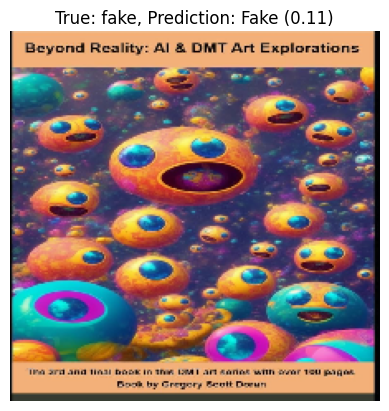

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


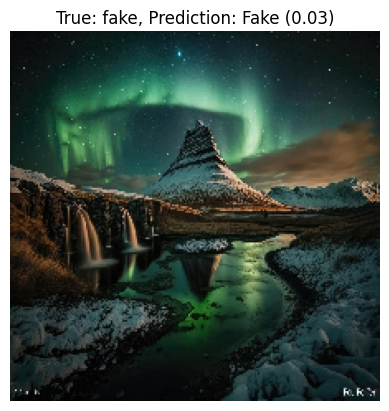

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


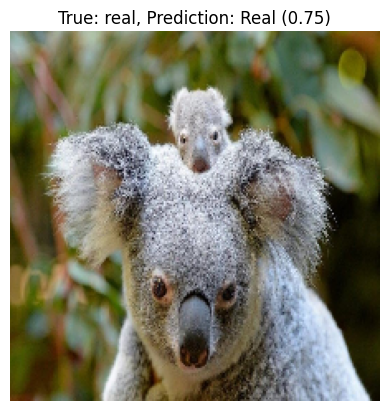

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


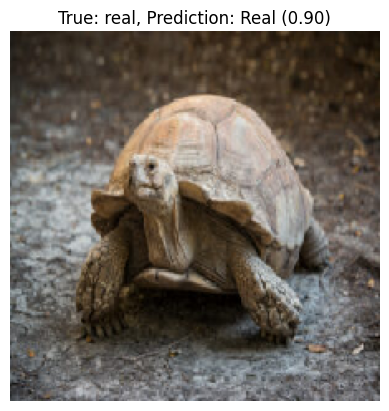

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


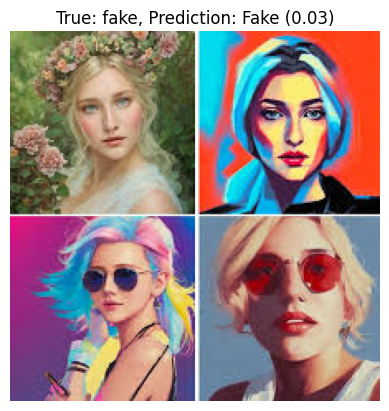

In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# -----------------------------
# Choose random images from train set
# -----------------------------
all_train_images = []  # will store (filepath, label)
for class_name, class_index in train_generator.class_indices.items():
    class_folder = os.path.join(train_dir, class_name)
    for img_file in os.listdir(class_folder):
        all_train_images.append((os.path.join(class_folder, img_file), class_name))

# Pick random images
num_images = 5
random_images = random.sample(all_train_images, num_images)

# -----------------------------
# Function to preprocess and predict
# -----------------------------
def predict_image(img_path, model, img_size=(224,224)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    prob = model.predict(img_array)[0][0]
    label = "Real" if prob > 0.5 else "Fake"
    return img, label, prob

# -----------------------------
# Display random images with predictions
# -----------------------------
for img_path, true_label in random_images:
    img, pred_label, prob = predict_image(img_path, model)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_label}, Prediction: {pred_label} ({prob:.2f})")
    plt.show()

In [3]:
import json

# Get class names from train_generator
class_indices = train_generator.class_indices

# Save class indices
with open("class_indices.json", "w") as f:
    json.dump(class_indices, f)

In [4]:
model.save("my_model.keras")